## **Building the RAG Pipeline**

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [3]:
load_dotenv(override=True)

True

In [10]:
DB = "products_vectorstore"


In [4]:
openai = OpenAI()

In [ ]:
# Loading the test dataset

with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [6]:
len(test)

2000

In [ ]:
# To provide the similar items as context to the LLM.

def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [8]:
def messages_for(item, similars, prices):
    system_message = "You estimate the prices of items. Reply only with the price, no explanation."
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")
    return [
        {'role': 'system', 'content': system_message}, 
        {'role': 'user', 'content': user_prompt}, 
        {'role': 'assistant', 'content': "Price is $"}
    ]

In [ ]:
# reviving the datastore

client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [ ]:
# to get the item description ONLY

def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [18]:
description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [20]:
# Here comes the Sentence Transformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


In [ ]:
# converting a description into a numpy array of embeddings

def vector(item):
    return model.encode([description(item)])

In [ ]:
# Our own RAG without any framework !!

def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [24]:
print((test[1].prompt))

How much does this cost to the nearest dollar?

Motorcraft YB3125 Fan Clutch
Motorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007

Price is $225.00


In [25]:
documents, prices = find_similars(test[1])

In [29]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Motorcraft Fan Clutch Assembly - YB3130
Motorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches
Price is $223.78

Potentially related product:
Motorcraft- YB3126 Fan Clutch
Fan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB3126 Package Weight 7.4 pounds Fit type Vehicle Specific Brand Motorcraft, Electric fan design Blower, Power Source Electric, Style Modern, Dimensi

In [30]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [31]:
# the function for GPT-4.1-nano

def gpt_4_nano_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model='gpt-4.1-nano', 
        messages=messages_for(item, documents, prices), 
        seed=42, 
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
gpt_4_nano_rag(test[1]), test[1].price    # Pretty close

(228.5, 225.11)

### **Let's put our RAG Pipeline to a Test**

1: Guess: $391.41 Truth: $374.41 Error: $17.00 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $228.50 Truth: $225.11 Error: $3.39 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $46.24 Truth: $61.68 Error: $15.44 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $12.99 Truth: $16.99 Error: $4.00 SLE: 0.06 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $9.99 Truth: $31.99 Error: $22.00 SLE: 1.21 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $68.99 Truth: $101.79 Error: $32.80 SLE: 0.15 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $459.00 Truth: $289.00 Error: $170.00 SLE: 0.21 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $650.00 Truth: $635.86 Error: $14.14 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $56.99 Truth: $65.99 Error: $9.00 SLE: 0.02 Item:

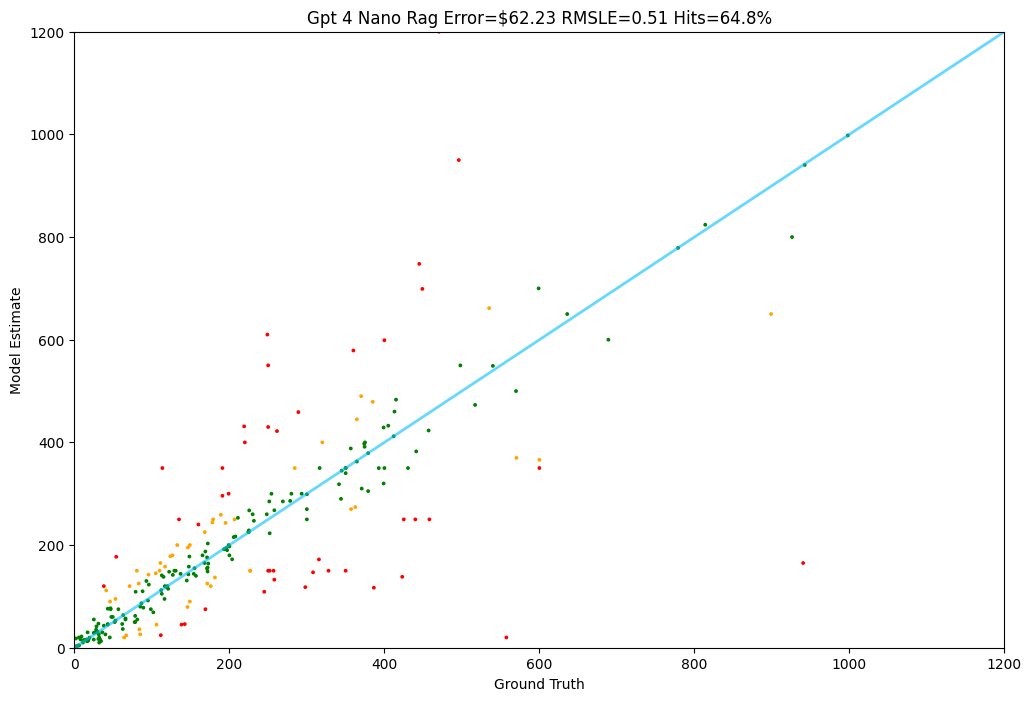

In [36]:
Tester.test(gpt_4_nano_rag, test)

> It's obvious that the RAG Pipeline is doing great !!  
> The results are a hell lot better than before when we tested with gpt-4o and gpt-4o mini